In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 14.8+ KB
None
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.0000

/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/seein/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

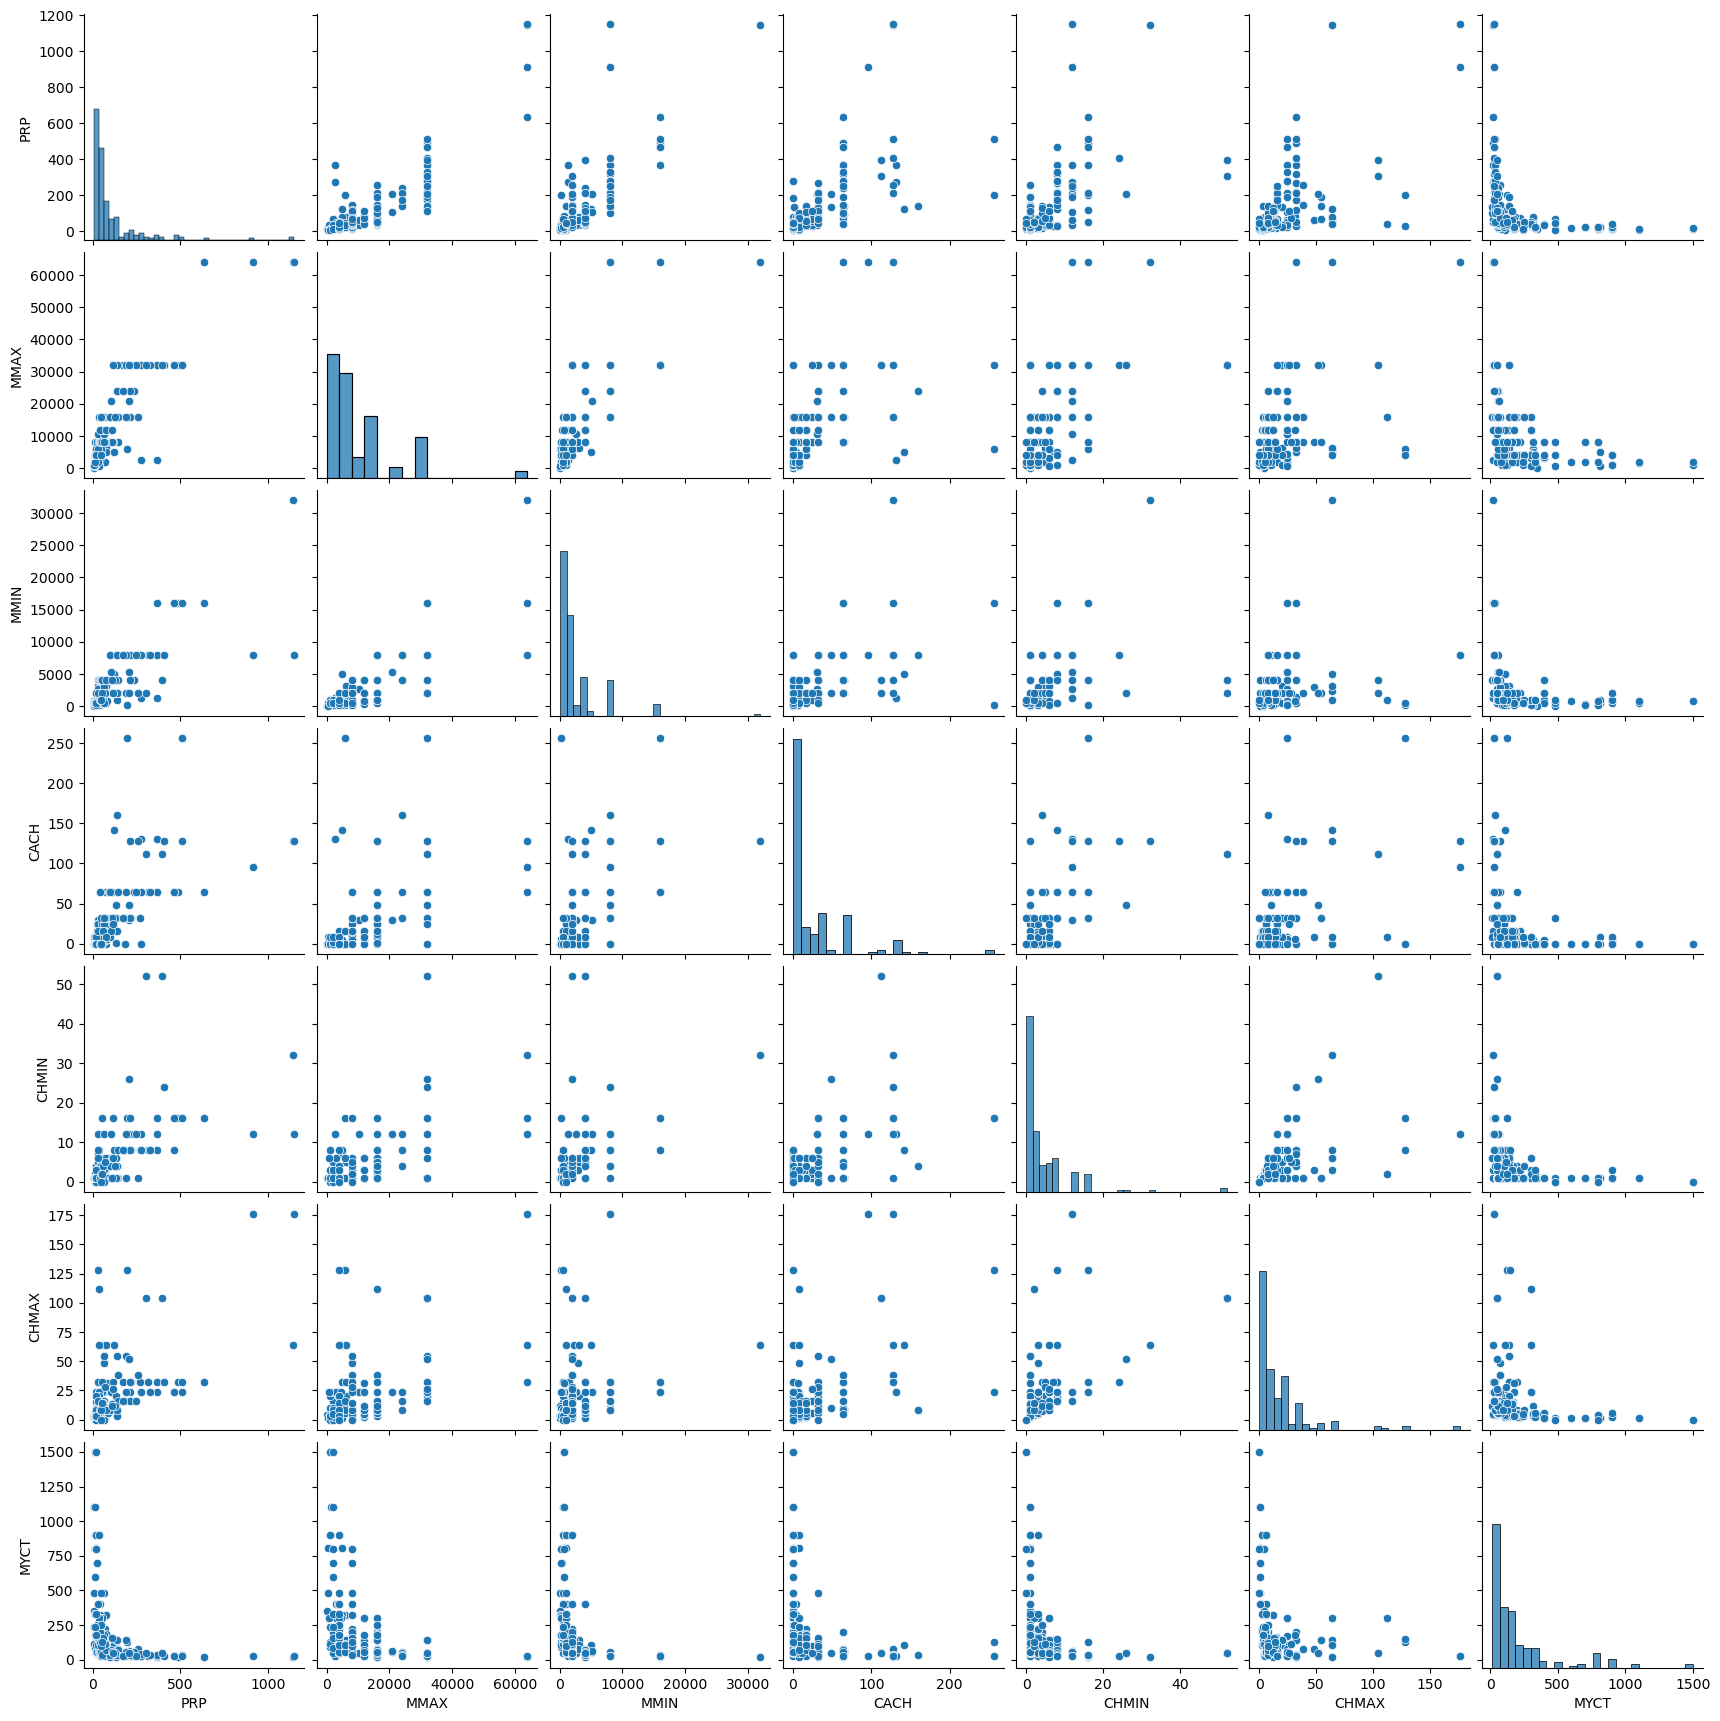

In [3]:
# 데이터 탐색 및 시각화
machine_data = pd.read_csv('machine_data.csv')

print(machine_data.info())
print(machine_data.describe())
print(machine_data.head())
print(machine_data.shape)

# 범주형 데이터 수치화
dum = pd.get_dummies(machine_data.VendorName, prefix='v', dtype=float)
machine_data = pd.concat([machine_data.drop('VendorName', axis=1), dum], axis =1)
dum = pd.get_dummies(machine_data['ModelName'], prefix='m',  dtype=float)
machine_data = pd.concat([machine_data.drop('ModelName', axis=1), dum], axis =1)

# 데이터분포 시각화
result = machine_data.corr()['PRP']
result = np.abs(result).sort_values(ascending=False)
print(result)

# feature 선택
features = ['PRP', 'MMAX', 'MMIN', 'CACH', 'CHMIN', 'CHMAX', 'MYCT']
sns.pairplot(machine_data[features])
plt.show()


In [4]:
# X, y 설정
num_features = ['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']
X = machine_data[num_features]
y = machine_data['PRP']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X.shape, y.shape

((209, 6), (209,))

In [5]:
# 앙상블 학습
# 1) 전처리 파이프라인 정의
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ]
)

# 2) 개별 모델 정의
models = [
    ('lr', LinearRegression()),
    ('sgd', SGDRegressor(random_state=42)),
    ('ridge', Ridge(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

# 3) 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 4) 앙상블 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 5) 하이퍼파라미터 튜닝
params_grid = {
    'ensemble__sgd__alpha': [0.001, 0.01],
    'ensemble__sgd__max_iter': [1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200], 
    'ensemble__gbr__learning_rate': [0.01, 0.1]
}
# 6) GridSearchCV 모델 설정 및 학습 및 성능 평가
grid_search_mse = GridSearchCV(model_pipeline, params_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search_mae = GridSearchCV(model_pipeline, params_grid, cv = 5, scoring='neg_mean_absolute_error' , return_train_score=True )
# grid_search_r2 = GridSearchCV(model_pipeline, params_grid, cv = 5, scoring='r2' , return_train_score=True )

grid_search_mse.fit(X_train, y_train)
# grid_search_mae.fit(X_train, y_train)
# grid_search_r2.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MYCT',
                                                                          'MMIN',
                                                                          'MMAX',
                                                                          'CACH',
                                                                          'CHMIN',
                                                                          'CHMAX'])])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor(random_state=42)),
                                                                    ('ridge',
                                                                     Ridge(random_state=42)),
                                                                    ('gbr',
                                                                     GradientBoostingRegressor(random_state=42))]))]),
             param_grid={'ensemble__gbr__learning_rate': [0.01, 0.1],
                         'ensemble__gbr__n_estimators': [100, 200],
                         'ensemble__ridge__alpha': [10, 20],
                         'ensemble__sgd__alpha': [0.001, 0.01],
                         'ensemble__sgd__max_iter': [1000, 2000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [6]:
# 최적 파라미터 출력
print(f'Best parameters for MSE: {grid_search_mse.best_params_}\n')
# print(f'Best parameters for MAE: {grid_search_mae.best_params_}\n')
# print(f'Best parameters for R2: {grid_search_r2.best_params_}')

# 최적 모델 출력
best_model_mse = grid_search_mse.best_estimator_
# best_model_mae = grid_search_mae.best_estimator_
# best_model_r2 = grid_search_r2.best_estimator_

# 최적 모델로 예측
y_train_pred = best_model_mse.predict(X_train)
y_test_pred = best_model_mse.predict(X_test)


Best parameters for MSE: {'ensemble__gbr__learning_rate': 0.1, 'ensemble__gbr__n_estimators': 100, 'ensemble__ridge__alpha': 20, 'ensemble__sgd__alpha': 0.01, 'ensemble__sgd__max_iter': 1000}



In [7]:
# 최적 모델로 성능 평가
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f'<훈련 데이터 성능>\nMSE = {mse_train}\nMAE = {mae_train}\nR2 = {r2_train}')

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'<테스트 데이터 성능>\nMSE = {mse_test}\nMAE = {mae_test}\nR2 = {r2_test}')

<훈련 데이터 성능>
MSE = 1884.9071539690297
MAE = 27.100247831736926
R2 = 0.9019526147324272
<테스트 데이터 성능>
MSE = 4771.063955706039
MAE = 40.93620955549851
R2 = 0.906278552725662


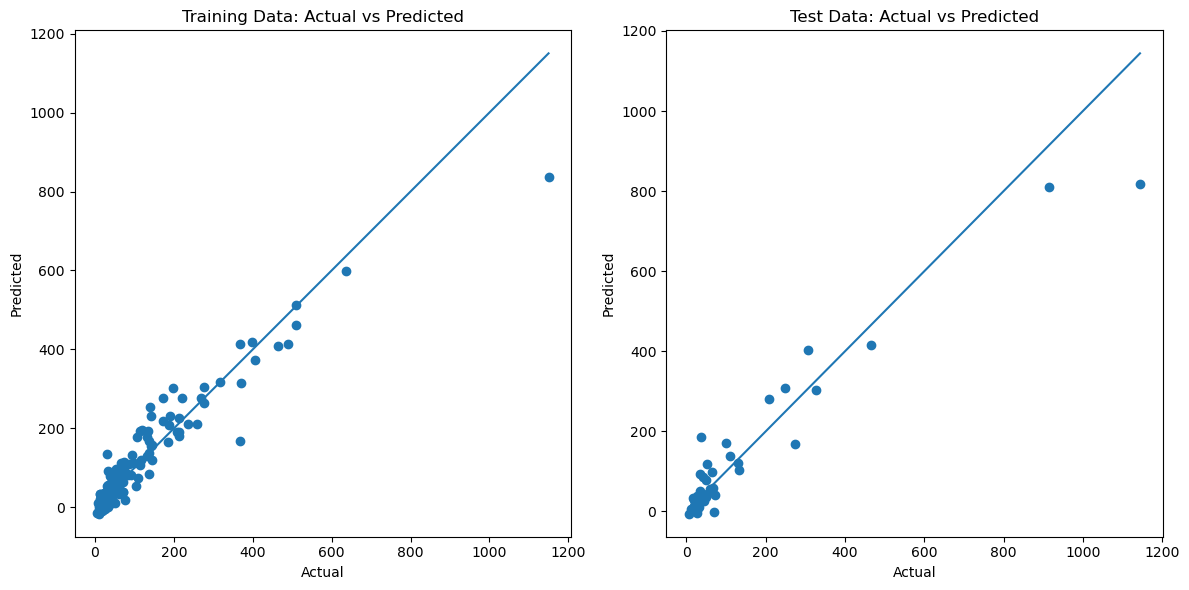

In [8]:
# 실제 데이터와 예측 데이터 비교 (훈련 데이터)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, label='Actual PRP')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', label='Predicted PRP')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Training Data: Actual vs Predicted')

# 실제 데이터와 예측 데이터 비교 (테스트 데이터)
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, label='Actual PRP')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='Predicted PRP')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Test Data: Actual vs Predicted')

d
plt.tight_layout()
plt.show()